# Modèle pour API

In [1]:
image_size = 224
num_channels = 3
num_classes = 120
project_path ='Documents/OC_Ingenieur_ML/P6_Classez_des_images/'

from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model,callbacks
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

# Récupérer la sortie de ce réseau
x = model.layers[-2].output

# Ajouter la nouvelle couche fully-connected pour la classification à 10 classes

predictions = Dense(num_classes, activation='softmax')(x)

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)

# Figer tous les poids
for layer in new_model.layers[:]:
    layer.trainable = False

In [2]:
import tensorflow as tf
%cd
# Compiler le modèle
new_model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=["accuracy"])

new_model.load_weights(project_path+'models/model120_weights.h5')
new_model.save(project_path+'models/model120.h5')
new_model.summary()

/home/fedecabre
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 1

In [3]:
from keras.preprocessing.image import ImageDataGenerator
import pickle

crop_images_folders_path = project_path+"data/Cropped/"

datagen = ImageDataGenerator()

generator = datagen.flow_from_directory(crop_images_folders_path,
                                                target_size=(image_size, image_size),
                                                batch_size=32,
                                                subset="training",
                                                class_mode='categorical')

num_classes = generator.num_classes
train_size = generator.n
races = generator.class_indices.keys()
races_dict = generator.class_indices
races_invert_dict = {v: k for k, v in races_dict.items()}

races_invert_dict_file = open(project_path+"models/races_invert_dict.pkl", "wb")
pickle.dump(races_invert_dict, races_invert_dict_file)
races_invert_dict_file.close()

races_invert_dict_file = open(project_path+"models/races_invert_dict.pkl", "rb")
races_invert_dict = pickle.load(races_invert_dict_file)
races_invert_dict

Found 20579 images belonging to 120 classes.


{0: 'n02085620-Chihuahua',
 1: 'n02085782-Japanese_spaniel',
 2: 'n02085936-Maltese_dog',
 3: 'n02086079-Pekinese',
 4: 'n02086240-Shih_Tzu',
 5: 'n02086646-Blenheim_spaniel',
 6: 'n02086910-papillon',
 7: 'n02087046-toy_terrier',
 8: 'n02087394-Rhodesian_ridgeback',
 9: 'n02088094-Afghan_hound',
 10: 'n02088238-basset',
 11: 'n02088364-beagle',
 12: 'n02088466-bloodhound',
 13: 'n02088632-bluetick',
 14: 'n02089078-black-and-tan_coonhound',
 15: 'n02089867-Walker_hound',
 16: 'n02089973-English_foxhound',
 17: 'n02090379-redbone',
 18: 'n02090622-borzoi',
 19: 'n02090721-Irish_wolfhound',
 20: 'n02091032-Italian_greyhound',
 21: 'n02091134-whippet',
 22: 'n02091244-Ibizan_hound',
 23: 'n02091467-Norwegian_elkhound',
 24: 'n02091635-otterhound',
 25: 'n02091831-Saluki',
 26: 'n02092002-Scottish_deerhound',
 27: 'n02092339-Weimaraner',
 28: 'n02093256-Staffordshire_bullterrier',
 29: 'n02093428-American_Staffordshire_terrier',
 30: 'n02093647-Bedlington_terrier',
 31: 'n02093754-Border_

In [4]:
import cv2

image_path = project_path+'data/COCO/coco.jpg'
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
image = image.reshape(1, 224, 224, 3)
prediction = new_model.predict(image)[0]
top3 = prediction.argsort()[::-1][:3]
top3_list = []
for i in top3:
    print(races_invert_dict[i].split('-')[1],prediction[i])
    top3_list.append(races_invert_dict[i].split('-')[1]+" = "+str(prediction[i]))

Lhasa 0.63208
Pekinese 0.35512802
Shih_Tzu 0.011014086


<a name='3-1'></a>
### 3.1 - Defining Classes, Anchors and Image Shape

You're trying to detect 80 classes, and are using 5 anchor boxes. The information on the 80 classes and 5 boxes is gathered in two files: "coco_classes.txt" and "yolo_anchors.txt". You'll read class names and anchors from text files. The car detection dataset has 720x1280 images, which are pre-processed into 608x608 images.

In [5]:
from yad2k.utils.utils import get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor

from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image

%matplotlib inline
class_names = read_classes(project_path+"models/coco_classes.txt")
anchors = read_anchors(project_path+"models/yolo_anchors.txt")
model_image_size = (608, 608)  # Same as yolo_model input layer size

<a name='3-2'></a>
### 3.2 - Loading a Pre-trained Model

Training a YOLO model takes a very long time and requires a fairly large dataset of labelled bounding boxes for a large range of target classes. You are going to load an existing pre-trained Keras YOLO model stored in "yolo.h5". These weights come from the official YOLO website, and were converted using a function written by Allan Zelener. References are at the end of this notebook. Technically, these are the parameters from the "YOLOv2" model, but are simply referred to as "YOLO" in this notebook.

Run the cell below to load the model from this file.

In [6]:
from tensorflow.keras.models import load_model

yolo_model = load_model(project_path+"models/YOLO/", compile=False)

In [7]:
yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 608, 608, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 608, 608, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])


In [9]:
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    ### START CODE HERE
    # Retrieve outputs of the YOLO model (≈1 line)
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    
    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    
    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)
    
    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes = max_boxes, iou_threshold = iou_threshold)
    ### END CODE HERE
    
    return scores, boxes, classes

In [10]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4)
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
                     then get rid of the corresponding box

    Returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    x = 10
    y = tf.constant(100)
    
    ### START CODE HERE
    # Step 1: Compute box scores
    ##(≈ 1 line)
    box_scores = box_confidence*box_class_probs

    # Step 2: Find the box_classes using the max box_scores, keep track of the corresponding score
    ##(≈ 2 lines)
    box_classes = tf.math.argmax(box_scores,axis=-1)
    box_class_scores = tf.math.reduce_max(box_scores,axis=-1)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    ## (≈ 1 line)
    filtering_mask = (box_class_scores>=threshold)
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
    ## (≈ 3 lines)
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    ### END CODE HERE
    
    return scores, boxes, classes

In [11]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()

    ### START CODE HERE
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ##(≈ 1 line)
    nms_indices = tf.image.non_max_suppression(   boxes,
                                                  scores,
                                                  max_boxes_tensor,
                                                  iou_threshold=iou_threshold,
                                                  name=None
                                                )
    
    # Use tf.gather() to select only nms_indices from scores, boxes and classes
    ##(≈ 3 lines)
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    ### END CODE HERE

    
    return scores, boxes, classes

In [12]:
def draw_boxes(image, boxes, box_classes, class_names, scores=None):
    """Draw bounding boxes on image.

    Draw bounding boxes with class name and optional box score on image.

    Args:
        image: An `array` of shape (width, height, 3) with values in [0, 1].
        boxes: An `array` of shape (num_boxes, 4) containing box corners as
            (y_min, x_min, y_max, x_max).
        box_classes: A `list` of indicies into `class_names`.
        class_names: A `list` of `string` class names.
        `scores`: A `list` of scores for each box.

    Returns:
        A copy of `image` modified with given bounding boxes.
    """
    #image = Image.fromarray(np.floor(image * 255 + 0.5).astype('uint8'))

    font = ImageFont.truetype(
        font=project_path+'models/font/FiraMono-Medium.otf',
        size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    colors = get_colors_for_classes(len(class_names))

    for i, c in list(enumerate(box_classes)):
        box_class = class_names[c]
        box = boxes[i]
        
        if isinstance(scores.numpy(), np.ndarray):
            score = scores.numpy()[i]
            label = '{} {:.2f}'.format(box_class, score)
        else:
            label = '{}'.format(box_class)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

    return np.array(image)


In [13]:
from yad2k.models.keras_yolo import yolo_head

def predict(image_file):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image(image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    #image.save(os.path.join(image_file), quality=100)
    # Display the results in the notebook
    #output_image = Image.open(os.path.join(image_file))
    imshow(image)

    return out_scores, out_boxes, out_classes, image, image_data

Found 5 boxes for images/Documents/OC_Ingenieur_ML/P6_Classez_des_images/data/COCO/dogs-age-years..jpg
dog 0.90 (1906, 512) (2426, 1159)
dog 0.84 (60, 497) (702, 1159)
dog 0.82 (1398, 581) (1927, 1154)
dog 0.71 (900, 418) (1571, 1131)
dog 0.43 (336, 363) (1139, 1156)


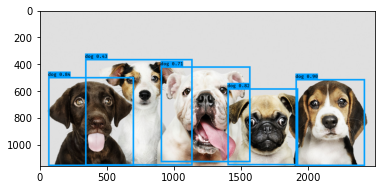

In [14]:
import cv2

image_path = project_path+'data/COCO/dogs-age-years..jpg'

out_scores, out_boxes, out_classes, image, image_data = predict(image_path)

plt.imshow(np.array(image))

beagle 0.6888765
Walker_hound 0.21838777
English_foxhound 0.09115459
Labrador_retriever 0.9555619
flat_coated_retriever 0.042630624
German_short 0.0016818682
pug 0.99743843
Brabancon_griffon 0.0025609983
Boston_bull 5.409501e-07
French_bulldog 0.6457913
pug 0.3393692
bull_mastiff 0.01240234
Italian_greyhound 0.17890693
whippet 0.16919048
American_Staffordshire_terrier 0.16403195


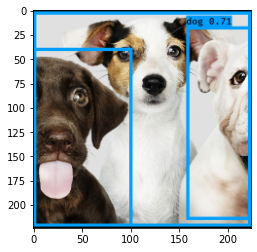

In [15]:
from keras.applications.vgg16 import preprocess_input

for i,j in enumerate(out_classes):
    if j==16: # 16 est la classe chien de YOLO
        top, left, bottom, right = out_boxes[i]
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        image_crop = np.array(image)[top:bottom, left:right]

        #bounding carré rempli de noir
        x = right-left
        y = bottom-top

        if x<y:
            squarre_image = np.zeros((y,y,num_channels))
            delta = ((y-x)//2)
            squarre_image[:image_crop.shape[0],delta:(image_crop.shape[1])+delta,:] = image_crop
            squarre_image = squarre_image.astype(np.uint8)
        if x>y:
            squarre_image = np.zeros((x,x,num_channels))
            delta = ((x-y)//2)
            squarre_image[delta:(image_crop.shape[0]+delta),:image_crop.shape[1],:] = image_crop
            squarre_image = squarre_image.astype(np.uint8)
        else:
            squarre_image = image_crop.astype(np.uint8)

        image_dog = cv2.resize(squarre_image, (224, 224), interpolation=cv2.INTER_AREA)
        image_dog = image_dog.reshape(1, 224, 224, 3)
        plt.imshow(image_dog[0])
        image_dog = preprocess_input(image_dog)
        prediction = new_model.predict(image_dog)[0]
        top3 = prediction.argsort()[::-1][:3]
        top3_list = []
        for i in top3:
            print(races_invert_dict[i].split('-')[1],prediction[i])
            top3_list.append(races_invert_dict[i].split('-')[1]+" = "+str(prediction[i]))